In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import classification_report, confusion_matrix


In [71]:
path_to_files = "stock_data/"
# path_to_sentiments1 = "stock_news_sentiment_scores/2011-2024/stock_news_sentiment_analysis_results_"
path_to_sentiments = "stock_news_sentiment_scores/2011-2024/stock_news_sentiment_analysis_results_"
path_to_global_news = "news_sentiment_scores/2000-2024/sentiment_analysis_results_"

stock_symbols = ['GOOG', 'MSFT', 'NVDA','AMZN','AAPL']

interval = 14 # Time interval for Standard Moving Average calculation 
start_date = pd.to_datetime('2012-01-01').date()
end_date = pd.to_datetime('2023-01-01').date()



In [72]:
def categorize_change(x):
    if pd.isnull(x):
        return None  # For the first day
    elif x > 0:
        return 1
    else:
        return 0
    
def classify_price_difference(row):
    if row['PD'] > 0.5:  # Significant rise
        return 2
    elif row['PD'] < -0.5:  # Significant fall
        return 0
    else:
        return 1  # No significant change



def preprocess_and_merge_data(stock_symbols, start_date, end_date, interval):
    merged_data = {}
    X_features_ = None

    for symbol in stock_symbols:
        ## Load data
        df_sentiment = pd.read_csv(path_to_sentiments + symbol + ".csv")
        df_stock = pd.read_csv(path_to_files + symbol + "/stock_price.csv")
        df_news = pd.read_csv(path_to_global_news + symbol + ".csv") 

        ## Convert date columns
        df_sentiment['Date'] = pd.to_datetime(df_sentiment['Date'], utc=True).dt.date
        df_stock['Date'] = pd.to_datetime(df_stock['Date'], utc=True).dt.date
        df_news['Date'] = pd.to_datetime(df_news['Date'], utc=True).dt.date
        
        ## Rename columns
        rename_mapping1 = {
            'weighted positive sentiment score': 'Stock +ve Sentiment',
            'weighted negative sentiment score': 'Stock -ve Sentiment',
            'weighted neutral sentiment score': 'Stock Neutral',
            'weighted compound sentiment score': 'Stock Sentiment',
        }
        rename_mapping2 = {
            'weighted positive sentiment score': 'Global +ve Sentiment',
            'weighted negative sentiment score': 'Global -ve Sentiment',
            'weighted neutral sentiment score': 'Global Neutral',
            'weighted compound sentiment score': 'News Sentiment',
        }
        df_sentiment = df_sentiment.rename(columns=rename_mapping1)
        df_news = df_news.rename(columns=rename_mapping2)
        
        ## Filter by date range
        sentiment_filtered = df_sentiment[(df_sentiment['Date'] >= start_date) & (df_sentiment['Date'] <= end_date)]
        stock_filtered = df_stock[(df_stock['Date'] >= start_date) & (df_stock['Date'] <= end_date)]
        news_filtered = df_news[(df_news['Date'] >= start_date) & (df_news['Date'] <= end_date)]

        ## Remove 'Ticker' column
        sentiment_filtered = sentiment_filtered.drop(columns=['Ticker'])
        news_filtered = news_filtered.drop(columns=['Ticker'])
        
        ## Merge stock and sentiment data on common dates
        merged_df = pd.merge(stock_filtered, sentiment_filtered, on='Date', how='inner')

        ## Merge news data, filling missing values with zeros
        merged_df = pd.merge(merged_df, news_filtered, on='Date', how='left')
        news_columns = news_filtered.columns.tolist()
        news_columns.remove('Date')
        merged_df[news_columns] = merged_df[news_columns].fillna(0)

        ## Compute Features and assgin target variables 
        merged_df.sort_values('Date', inplace=True)

        merged_df['SMA'] = merged_df['Close'].rolling(window= interval).mean()
        merged_df['Difference'] = merged_df['Close'].diff()
        # merged_df['Trend'] = merged_df['Close'].diff().apply(categorize_change)
        merged_df['PD'] = merged_df['Close'].pct_change() * 100

        # Drop the first row where PD is NaN
        merged_df = merged_df.dropna(subset=['PD'])

        # Apply classify_price_difference function
        merged_df['Price Movement'] = merged_df.apply(classify_price_difference, axis=1)

        X_features_ = merged_df.columns.tolist()
        merged_data[symbol] = merged_df.dropna()  # Drop NA after adding features
        
    return merged_data, X_features_


In [73]:
stock_data, Xfeatures = preprocess_and_merge_data(stock_symbols, start_date, end_date, interval)
stock_data['GOOG']

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Stock +ve Sentiment,Stock -ve Sentiment,Stock Neutral,Stock Sentiment,Global +ve Sentiment,Global -ve Sentiment,Global Neutral,News Sentiment,SMA,Difference,PD,Price Movement
13,2012-07-30,15.803062,15.965799,15.640322,15.709890,87795852,0.0,0.0,0.111000,0.000000,0.889000,0.653000,0.0,0.000000,0.000000,0.000000,15.316371,0.533685,3.516589,2
14,2012-08-13,16.085557,16.401843,16.067172,16.398365,131205956,0.0,0.0,0.031000,0.099395,0.909898,-0.582518,0.0,0.000000,0.000000,0.000000,15.383011,0.688475,4.382428,2
15,2012-09-11,17.341254,17.408089,17.168329,17.197895,75232938,0.0,0.0,0.111000,0.057000,0.832000,0.624900,0.0,0.000000,0.000000,0.000000,15.476395,0.799530,4.875669,2
16,2012-09-24,18.162153,18.635214,18.143520,18.618816,143086320,0.0,0.0,0.282000,0.000000,0.718000,0.962200,0.0,0.270101,0.778891,-0.376388,15.766361,1.420921,8.262182,2
17,2012-10-18,18.771866,18.868266,16.795644,17.267712,499561487,0.0,0.0,0.152560,0.118161,0.819924,0.164248,0.0,0.000000,0.000000,0.000000,15.989102,-1.351105,-7.256663,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
881,2022-12-22,88.712142,88.961529,86.727019,88.043785,23656100,0.0,0.0,0.278349,0.169534,0.889406,0.419258,0.0,0.000000,0.000000,0.000000,92.873348,-1.985115,-2.204975,0
882,2022-12-23,87.405351,89.879272,87.405351,89.589981,17815000,0.0,0.0,0.184420,0.000000,0.903706,0.255013,0.0,0.000000,0.000000,0.000000,92.156536,1.546196,1.756167,2
883,2022-12-27,89.091209,89.280746,87.320563,87.714592,15470900,0.0,0.0,0.212000,0.000000,0.788000,0.223500,0.0,0.000000,0.000000,0.000000,91.488178,-1.875389,-2.093302,0
884,2022-12-28,87.285645,88.303143,86.158416,86.248192,17879600,0.0,0.0,0.000000,0.174000,0.970219,-0.226300,0.0,0.000000,0.000000,0.000000,90.868985,-1.466400,-1.671786,0


In [74]:


print(Xfeatures)

Features = [ 'Stock Sentiment', 'News Sentiment']
Stock_Metrics = ['SMA', 'Difference', 'Close', 'PD']
Trends = ['Price Movement']

print(type(stock_data['GOOG']))
print(stock_data['GOOG'].shape)



['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Stock +ve Sentiment', 'Stock -ve Sentiment', 'Stock Neutral', 'Stock Sentiment', 'Global +ve Sentiment', 'Global -ve Sentiment', 'Global Neutral', 'News Sentiment', 'SMA', 'Difference', 'PD', 'Price Movement']
<class 'pandas.core.frame.DataFrame'>
(873, 20)


In [75]:
# g = sns.pairplot(stock_data['GOOG'], x_vars=Features, y_vars=Targets)
# names = df.columns.map(lambda t: t.split('(')[0])
# for i in range(8):
#     g.axes[0,i].xaxis.set_label_text(names[i])
#     g.axes[0,i].yaxis.set_label_text(names[8])
# plt.show()
# # plt.show()

In [76]:
# plt.scatter(stock_data['GOOG']['weighted compound sentiment score'], stock_data['GOOG']['Price Difference'])

In [77]:
def train_predict(data, features, target):
    results = {}

    for ticker, df in data.items():
        # Train-test split
        split_index = int(len(df) * 0.9)
        train_data = df.iloc[:split_index]
        test_data = df.iloc[split_index:]
        # Separate features (X) and target (y)
        X_train = train_data[features]
        y_train = train_data[target]
        X_test = test_data[features]
        y_test = test_data[target]
        # print(X_train.sample(10))
        # print(X_test.sample(10))

        # Train XGBoost Model
        model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=10)
        model.fit(X_train, y_train)

        # Predictions
        y_pred = model.predict(X_test)

        # Evaluation
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred) 
        print(f"{ticker} - MSE: {mse:.4f}, MAE: {mae:.4f}")

        # Store Results
        results[ticker] = {
            'model': model,
            'mse': mse,
            'mae': mae,
            'y_test': y_test,
            'y_pred': y_pred
        }

    return results

def plot_predictions(results, target):
    for ticker, result in results.items():
        plt.figure(figsize=(10, 5))
        plt.plot(result['y_test'].values, label='Actual', marker='o', color = "RoyalBlue")
        plt.plot(result['y_pred'], label='Predicted', marker='x' , color = "Red")
        plt.title(f'{ticker} - Predicted vs Actual ({target})')
        plt.legend()
        plt.show()



In [78]:
results = []

param_grid = {"max_depth":    [4, 5, 6],
              "n_estimators": np.arange(100,800,100),
              "learning_rate": [0.01, 0.1, 1]}



for target in Stock_Metrics:
    print(target)
    res = train_predict(stock_data, Features, target)
    
    results.append(res)

SMA
GOOG - MSE: 487.0135, MAE: 17.1385
MSFT - MSE: 7631.2458, MAE: 65.0661
NVDA - MSE: 21.1386, MAE: 3.3791
AMZN - MSE: 1513.2503, MAE: 32.4720
AAPL - MSE: 3849.1280, MAE: 53.2680
Difference
GOOG - MSE: 7.1966, MAE: 2.0415
MSFT - MSE: 38.9282, MAE: 4.7577
NVDA - MSE: 0.5748, MAE: 0.5235
AMZN - MSE: 13.1758, MAE: 2.7198
AAPL - MSE: 12.8898, MAE: 2.7961
Close
GOOG - MSE: 440.5661, MAE: 17.2997
MSFT - MSE: 6396.5439, MAE: 59.2365
NVDA - MSE: 15.2563, MAE: 2.9081
AMZN - MSE: 1693.7130, MAE: 33.6236
AAPL - MSE: 3685.8492, MAE: 51.8209
PD
GOOG - MSE: 8.6261, MAE: 2.2149
MSFT - MSE: 7.7666, MAE: 2.2342
NVDA - MSE: 27.2593, MAE: 3.9681
AMZN - MSE: 12.3527, MAE: 2.4554
AAPL - MSE: 7.7250, MAE: 2.2464


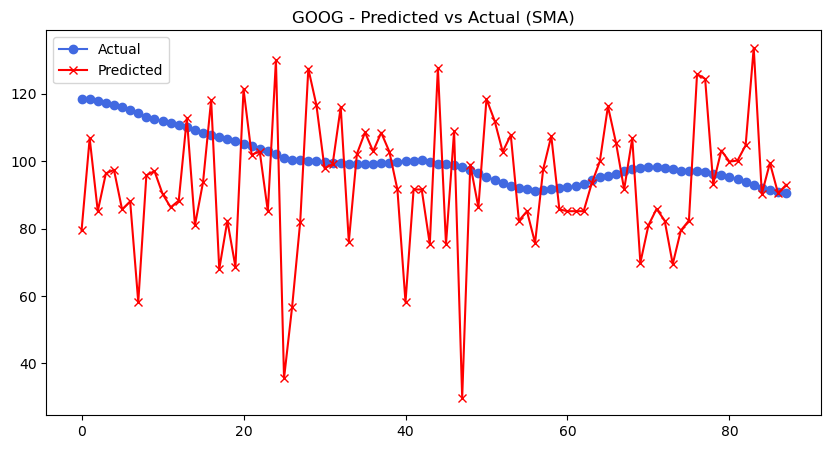

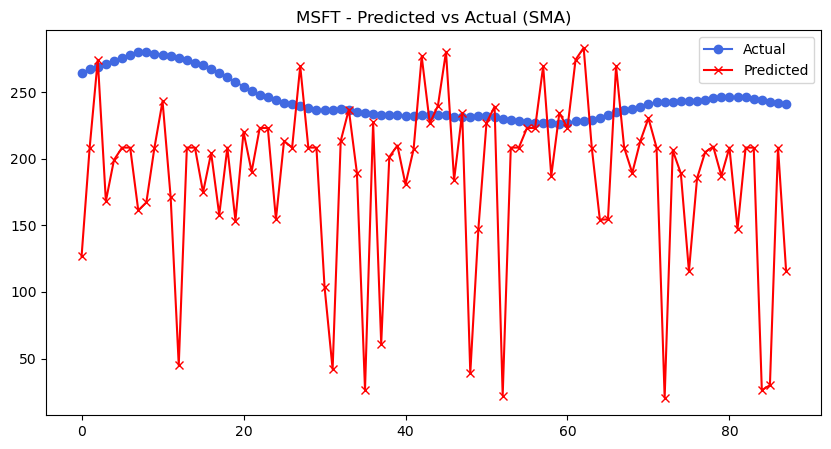

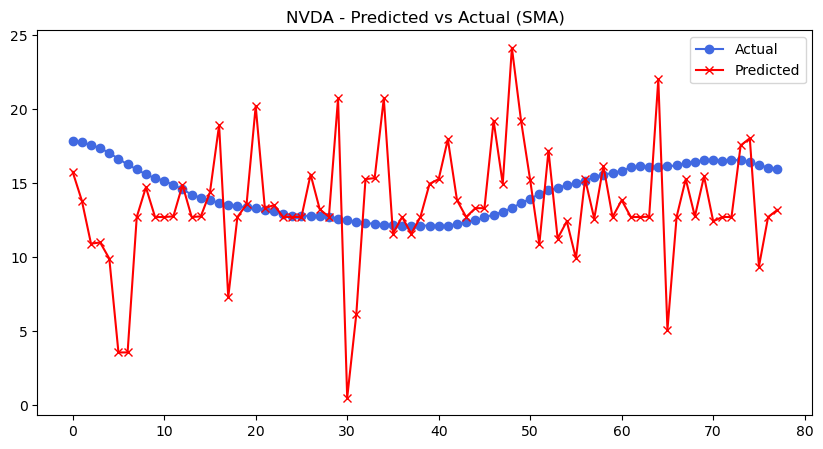

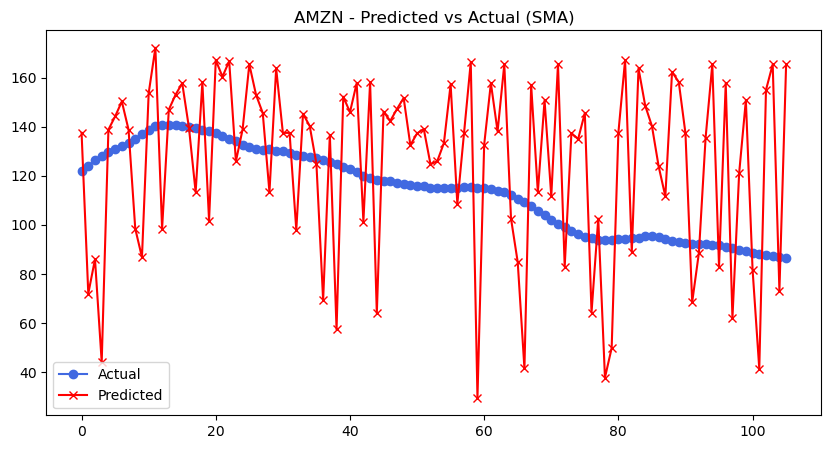

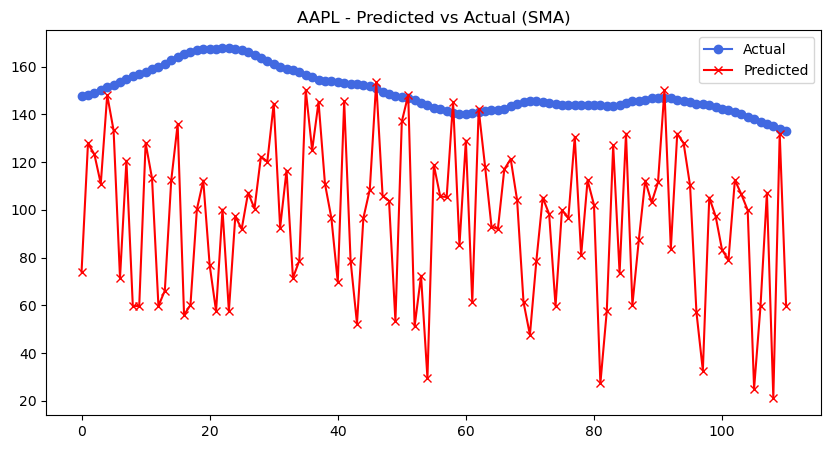

In [79]:
k = 0
plot_predictions(results[k], Stock_Metrics[k])

In [80]:
def train_predict_trend(data, features, target):
    results = {}

    for ticker, df in data.items():
        # Prepare data
        X = df[features]
        y = df[target]

        # Train-test split
        split_index = int(len(df) * 0.9)
        train_data = df.iloc[:split_index]
        test_data = df.iloc[split_index:]

        # Separate features (X) and target (y)
        X_train = train_data[features]
        y_train = train_data[target]
        X_test = test_data[features]
        y_test = test_data[target]

        model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
        model.fit(X_train, y_train)

        # Predictions
        y_pred = model.predict(X_test)

        # Evaluate
        print(f"Classification Report for {ticker}:")
        print(classification_report(y_test, y_pred))
        
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{ticker} - Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        # Store results
        results[ticker] = {
            'model': model,
            'y_test': y_test,
            'y_pred': y_pred
        }

    return results



Classification Report for GOOG:
              precision    recall  f1-score   support

           0       0.50      0.14      0.22        42
           1       0.09      0.06      0.07        16
           2       0.34      0.73      0.46        30

    accuracy                           0.33        88
   macro avg       0.31      0.31      0.25        88
weighted avg       0.37      0.33      0.28        88



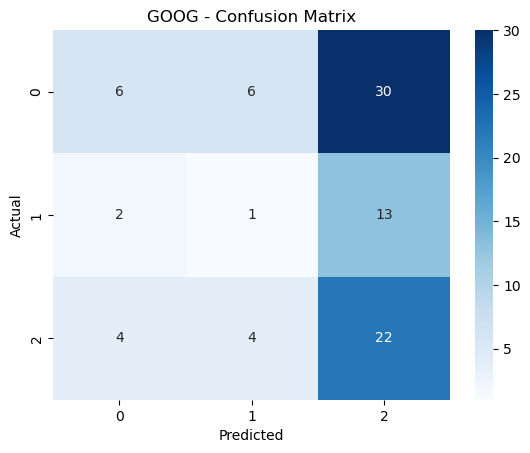

Classification Report for MSFT:
              precision    recall  f1-score   support

           0       0.54      0.38      0.44        40
           1       0.50      0.09      0.15        22
           2       0.36      0.77      0.49        26

    accuracy                           0.42        88
   macro avg       0.46      0.41      0.36        88
weighted avg       0.47      0.42      0.38        88



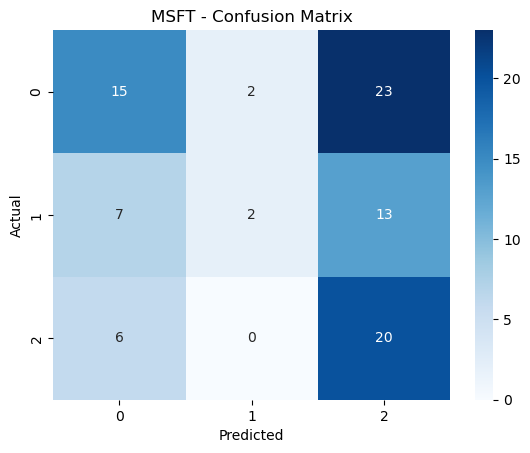

Classification Report for NVDA:
              precision    recall  f1-score   support

           0       0.62      0.33      0.43        40
           1       0.00      0.00      0.00         5
           2       0.48      0.82      0.61        33

    accuracy                           0.51        78
   macro avg       0.37      0.38      0.34        78
weighted avg       0.52      0.51      0.48        78



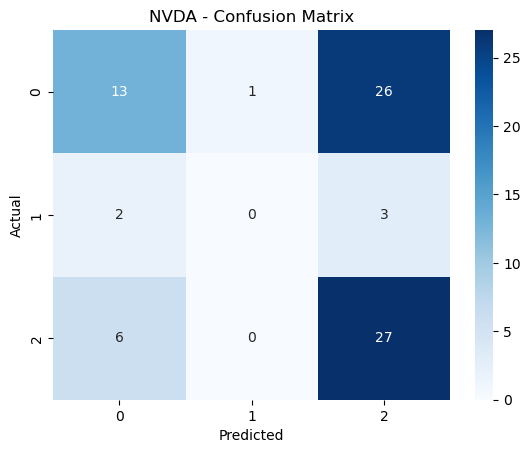

Classification Report for AMZN:
              precision    recall  f1-score   support

           0       0.53      0.16      0.24        57
           1       0.25      0.33      0.29        15
           2       0.33      0.68      0.45        34

    accuracy                           0.35       106
   macro avg       0.37      0.39      0.33       106
weighted avg       0.43      0.35      0.31       106



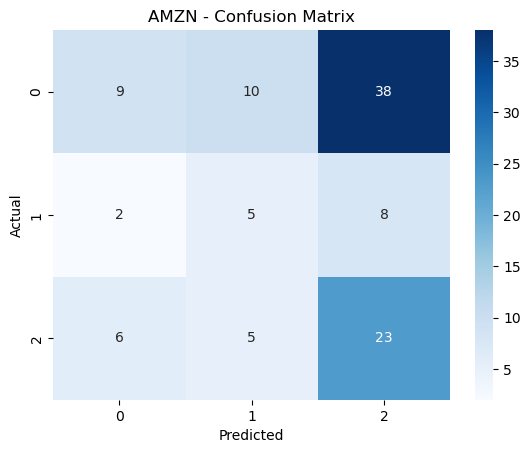

Classification Report for AAPL:
              precision    recall  f1-score   support

           0       0.50      0.33      0.40        48
           1       0.50      0.11      0.18        27
           2       0.38      0.78      0.51        36

    accuracy                           0.42       111
   macro avg       0.46      0.41      0.37       111
weighted avg       0.46      0.42      0.38       111



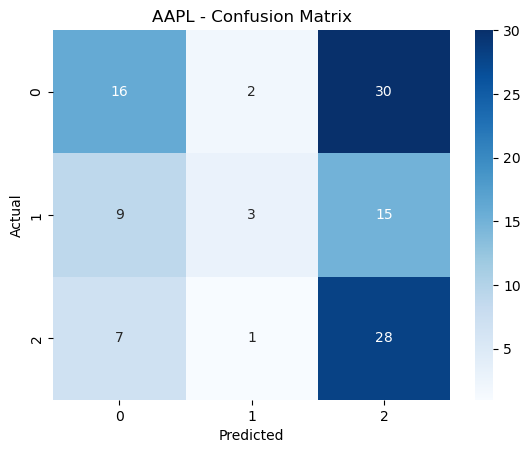

In [81]:

classification_results = train_predict_trend(stock_data, Features, target= 'Price Movement')
